[Demo code of DBSCAN](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py)

In [4]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import seaborn
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import Point

In [5]:
df_chicago=pd.read_csv('Crime/Crimes_-_2001_to_Present.csv',index_col='ID')
# clean the data without geocode and time stamp
df_chicago=df_chicago.dropna(subset=['Date','Location','Longitude','Latitude'])
df_chicago['Date']=pd.to_datetime(df_chicago['Date'])
# correct the value of crime type
df_chicago['Primary Type'].replace('CRIM SEXUAL ASSAULT','CRIMINAL SEXUAL ASSAULT',inplace=True)

In [6]:

import geopandas as gpd
#get geometry point of data
df_chicago['Location'] = df_chicago.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
# get geopandas frame
df_chicago=gpd.GeoDataFrame(df_chicago,geometry='Location')

In [7]:
# merge the basemap information so the latter analysis can be conduct based on the community

geof='Crime/Boundaries - Community Areas (current).geojson'
chicago_area=gpd.read_file(geof)
chicago_area=chicago_area[['community','area_numbe','geometry']]
chicago_area=chicago_area.rename(columns={'area_numbe':'area_num'})
df_chicago=df_chicago.set_crs(chicago_area.crs)

df_chicago= gpd.sjoin(df_chicago,chicago_area, how='inner',predicate='within')

In [9]:
df_chicago.head()

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,index_right,community,area_num
ID,,,,,,,,,,,,,,,,,,,,,
10224853,HY411790,2015-09-05 16:15:00,041XX W FIFTH AVE,1570,SEX OFFENSE,PUBLIC INDECENCY,SIDEWALK,True,False,1132,...,1148735.0,1896483.0,2015,09/17/2015 11:37:18 AM,41.871884,-87.729404,POINT (-87.72940 41.87188),26,WEST GARFIELD PARK,26
10232192,HY419551,2015-09-10 16:00:00,039XX W GLADYS AVE,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,RESIDENCE,False,True,1132,...,1150207.0,1898066.0,2015,02/10/2018 03:50:01 PM,41.876199,-87.723958,POINT (-87.72396 41.87620),26,WEST GARFIELD PARK,26
10329071,HY519515,2015-11-29 15:00:00,038XX W WILCOX ST,281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,OTHER,False,False,1122,...,1150799.0,1899061.0,2015,02/10/2018 03:50:01 PM,41.878918,-87.721758,POINT (-87.72176 41.87892),26,WEST GARFIELD PARK,26
10240564,HY428120,2015-09-17 20:00:00,039XX W WASHINGTON BLVD,281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1122,...,1150014.0,1900125.0,2015,02/10/2018 03:50:01 PM,41.881853,-87.724613,POINT (-87.72461 41.88185),26,WEST GARFIELD PARK,26
10242207,HY430128,2015-09-18 22:35:00,044XX W MADISON ST,1506,PROSTITUTION,SOLICIT ON PUBLIC WAY,SIDEWALK,True,False,1113,...,1146742.0,1899645.0,2015,02/10/2018 03:50:01 PM,41.880599,-87.736640,POINT (-87.73664 41.88060),26,WEST GARFIELD PARK,26


# KDE estimation

C:\Users\skyla\AppData\Local\Temp\ipykernel_16108\2274884605.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(data=df_chicago,


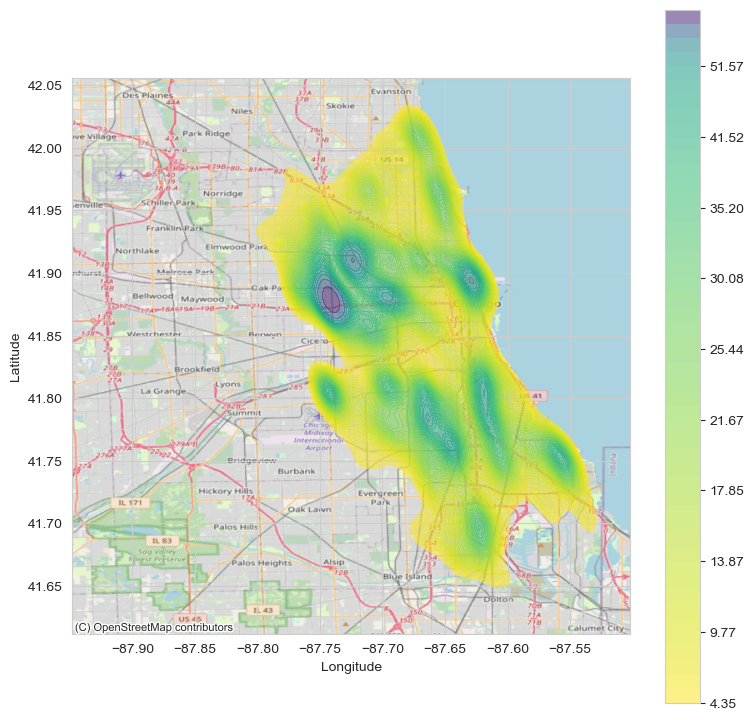

In [39]:
import contextily
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(data=df_chicago,
    x=df_chicago["Longitude"],
    y=df_chicago["Latitude"],
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
    legend=True,
                cbar=True
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=df_chicago.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)

# Clustering

In [8]:
# get data in Chicago south side

south=['Armour Square','Bridgeport','Douglas','Englewood','Fuller Park','Grand Boulevard','Greater Grand Crossing','Hyde Park','Kenwood','Oakland','South Shore','Washington Park','Woodlawn']
south= [i.upper() for i in south]


#subset the data by the targeted area in Chicago
# match by name of communities
south_chicago = df_chicago[df_chicago["community"].isin(south)]

In [19]:
westside=['Austin','Humboldt Park','West Town','South Lawndale','Near West Side','West Garfield Park','East Garfield Park','North Lawndale','Lower West Side']
westside= [i.upper() for i in westside]
#subset the data by the targeted area in Chicago
# match by name of communities
west_chicago = df_chicago[df_chicago["community"].isin(westside)]
west_chicago.community.unique()

array(['WEST GARFIELD PARK', 'HUMBOLDT PARK', 'SOUTH LAWNDALE',
       'NORTH LAWNDALE', 'WEST TOWN', 'AUSTIN', 'NEAR WEST SIDE',
       'EAST GARFIELD PARK', 'LOWER WEST SIDE'], dtype=object)

array(['WEST GARFIELD PARK', 'HUMBOLDT PARK', 'RIVERDALE',
       'BRIGHTON PARK', 'CHICAGO LAWN', 'WEST ENGLEWOOD', 'PORTAGE PARK',
       'WEST ELSDON', 'NEAR NORTH SIDE', 'GARFIELD RIDGE', 'WEST LAWN',
       'HYDE PARK', 'GAGE PARK', 'SOUTH LAWNDALE', 'WEST RIDGE',
       'BELMONT CRAGIN', 'WEST PULLMAN', 'SOUTH SHORE', 'AUBURN GRESHAM',
       'ROSELAND', 'LAKE VIEW', 'NORTH LAWNDALE', 'CALUMET HEIGHTS',
       'GREATER GRAND CROSSING', 'JEFFERSON PARK', 'BEVERLY', 'CHATHAM',
       'ROGERS PARK', 'AVALON PARK', 'LOOP', 'ASHBURN', 'UPTOWN',
       'ENGLEWOOD', 'WEST TOWN', 'DOUGLAS', 'WASHINGTON HEIGHTS',
       'SOUTH DEERING', 'LINCOLN PARK', 'IRVING PARK', 'NORWOOD PARK',
       'KENWOOD', 'NEW CITY', 'CLEARING', 'OAKLAND', 'AUSTIN',
       'LOGAN SQUARE', 'NEAR SOUTH SIDE', 'SOUTH CHICAGO',
       'NEAR WEST SIDE', 'GRAND BOULEVARD', 'EDISON PARK',
       'EAST GARFIELD PARK', 'LOWER WEST SIDE', 'LINCOLN SQUARE',
       'BRIDGEPORT', 'FULLER PARK', 'WASHINGTON PARK', 'AVONDALE

# preprocess data
Extract the lat, lon into a numpy matrix of coords


In [22]:
coords=np.array(south_chicago[['Longitude','Latitude']],dtype='float64')
#coords= np.radians(coords)  # Convert lat/long to radians


## Parameter selection
Elbow methods

In [21]:
from sklearn import preprocessing, cluster
import scipy

# K-means
 Partition the points into a predefined number of clusters


In [28]:
#plotting the variance as a function of the number of clusters and picking the k that flats the curve.
from sklearn.cluster import KMeans
max_k= 30
# iterate
distortions=[]
for i in range(1,max_k+1):
    if len(coords)>=i:
        #init: Number of times the k-means algorithm is run with different centroid seeds.
        model=KMeans(n_clusters=i,init='k-means++',n_init=10, random_state=0)
        model.fit(coords)
        # record the variance
        #Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
        distortions.append(model.inertia_)
distortions

[36.29195044803096,
 19.10715727078222,
 9.990558202919262,
 6.951927282235542,
 5.221244025062654,
 4.4105307437043155,
 3.7381791017737447,
 3.1888093067506906,
 2.6489251160244387,
 2.2342810437723077,
 2.0294980952106907,
 1.8526011249873067,
 1.6875802933983837,
 1.5507100006540595,
 1.4481167111926434,
 1.3555018834261727,
 1.2740675206958239,
 1.1939688125799341,
 1.145724313285422,
 1.0771495123256485,
 0.9861355615870249,
 0.9551652350429748,
 0.90004364246069,
 0.8606019371124906,
 0.8354036866791935,
 0.7921239247339265,
 0.7600609749673803,
 0.7238472684470597,
 0.7058852183723926,
 0.6814416218370483]

In [25]:
# find the best k with lowest derivative
k=[i*100 for i in np.diff(distortions,2)].index(min([i*100 for i
     in np.diff(distortions,2)]))



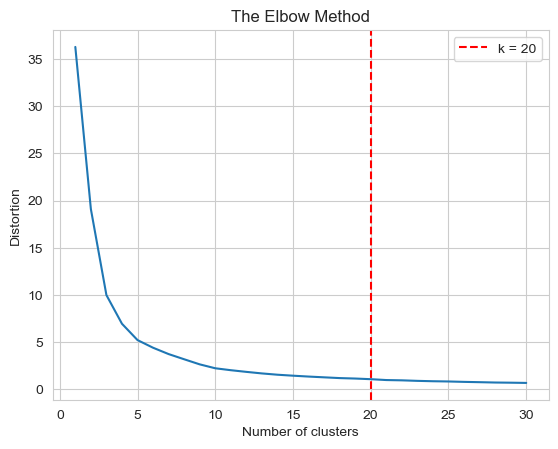

In [26]:
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters',
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [29]:
kmeans=cluster.KMeans(n_clusters=20,init='k-means++',n_init=10, random_state=0)
kmeans_cluster=kmeans.fit(coords)


In [20]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088
epsilon=0.05/kms_per_radian


In [103]:
model=DBSCAN(eps=epsilon,min_samples=1,algorithm='ball_tree',metric='haversine')
clusters=model.fit(np.radians(coords))
labels=clusters.labels_
num_clusters=len(set(labels))
print(f'Number of clusters: {len(set(labels))}')

Number of clusters: 25


## Hyperparameter
The epsilon parameter is the max distance (1.5 km in this example) that points can be from each other to be considered a cluster. The min_samples parameter is the minimum cluster size (everything else gets classified as noise).

In [32]:
# use nearest neighbot to find the appropriate epsilon
from sklearn.neighbors import NearestNeighbors
nbrs=NearestNeighbors(n_neighbors=5,algorithm='ball_tree',metric='haversine').fit(np.radians(coords))

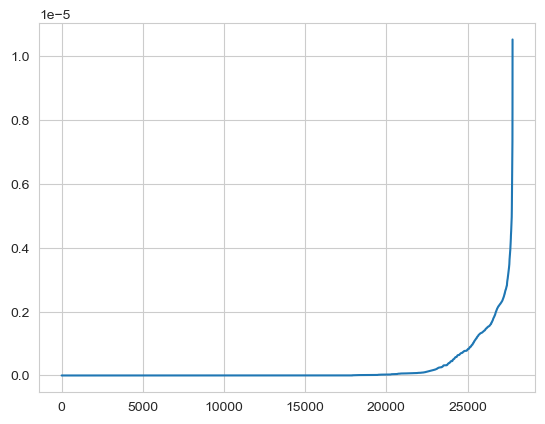

In [34]:

distances, indices =nbrs.kneighbors(np.radians(coords))
distances= np.sort(distances,axis=0)[:,1]
plt.plot(distances)


Haversine Metric:
The haversine metric is a great choice for clustering spatial locations because it takes into account the curvature of the earth's surface. This is important because distances between points on a sphere (like the earth) are different from distances on a flat plane. The haversine metric calculates the distance between two points on a sphere, such as the earth, by taking into account the earth's radius and the latitude and longitude of the two points. This means that the distances calculated using the haversine metric are more accurate for spatial locations.

Ball Tree Algorithm:
The ball tree algorithm is a spatial indexing algorithm that is efficient for clustering spatial data. It works by recursively partitioning the data into smaller regions, where each region is defined by a center point and a radius. This allows the algorithm to quickly identify nearby points without having to calculate the distance between every pair of points. The ball tree algorithm is particularly useful when the dataset is large or when there are a large number of dimensions in the data, as it can significantly reduce the number of distance calculations needed for clustering.

Overall, using the haversine metric and ball tree algorithm together can lead to more accurate and efficient clustering of spatial locations.






In [106]:
# visualise the clustering
# Note: due to the high volume of data, only the spatially representative points are chosen to visualise
# In this case, the point nearest the cluster's centroid was chosen as representative point.
# the function returns the center-most point from a cluster by taking a set of points (i.e., a cluster) and returning the point within it that is nearest to some reference point (in this case, the cluster’s centroid):

# store the result of clustering in a pandas series
clusters=pd.Series([coords[labels==n] for n in range(num_clusters)])
clusters

0     [[-87.604940233, 41.790894592], [-87.603927131...
1     [[-87.589078944, 41.798954417], [-87.586943342...
2     [[-87.579124719, 41.796205589], [-87.579218261...
3     [[-87.597495331, 41.800913166], [-87.597598015...
4     [[-87.581724977, 41.795251156], [-87.581599334...
5     [[-87.551092573, 41.754823635], [-87.562718202...
6                       [[-87.549347579, 41.753659136]]
7                        [[-87.59451432, 41.758689629]]
8     [[-87.651006106, 41.766923387], [-87.650554067...
9     [[-87.654144229, 41.766195532], [-87.654387423...
10    [[-87.654681247, 41.833452836], [-87.653503477...
11    [[-87.647527682, 41.844969184], [-87.6464681, ...
12    [[-87.662651723, 41.839380615], [-87.66248252,...
13    [[-87.660198943, 41.840562765], [-87.660265312...
14    [[-87.643973286, 41.843081808], [-87.644739198...
15    [[-87.661873492, 41.839754776], [-87.661617176...
16    [[-87.660840305, 41.837490202], [-87.66095442,...
17    [[-87.64584284, 41.845337819], [-87.645749

In [120]:
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
def get_rep_point(c):
    centroid=(MultiPoint(c).centroid.x, MultiPoint(c).centroid.y)
    centermost_point = min(c, key=lambda point: great_circle(point, centroid).m)    #min() is used t
    return tuple(centermost_point)
#gets the center-most point and then assembles all these center-most points into a new series
centermost_points = clusters.map(get_rep_point)

In [123]:
lat,lon= zip(*centermost_points)
# create a pd data frame of points to represent clusters
rep_points=pd.DataFrame({'Latitude':lat,'Longitude':lon})

In [122]:
# now pull the row from the original data set with matching latitude and longitude
#rs = rep_points.apply(lambda row: south_chicago[(['Latitude']==row['Latitude']) (south_chicago['Longitude']==row['Longitude'])].iloc[0], axis=1)
rs = rep_points.merge(south_chicago,on=['Longitude','Latitude'])
rs


,Longitude,Latitude,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Location,index_right,community,area_num


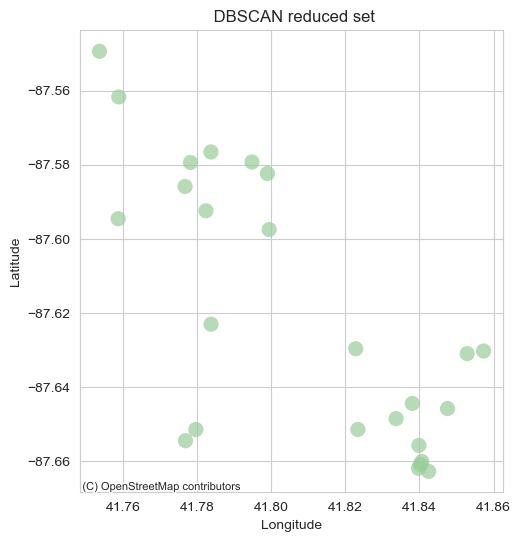

In [128]:
# Visualise the centroid of the cluster: spatially representative
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(x=rep_points['Longitude'],y= rep_points['Latitude'],c='#99cc99', edgecolor='None', alpha=0.7, s=120)
#df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_title(' DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')


# Add basemap
contextily.add_basemap(
    ax,
    crs=south_chicago.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)


# K- means


# Gaussian Mixtures


# Clustering evaluation


In [ ]:
from sklearn import metrics
